# Udacity Machine Learning Capstone Project

## Falls Creek Snow Depth Forecast

This project uses time series data spread over days to predict future data points, where we look to explore

> Snow - 'https://raw.githubusercontent.com/boffyd/UdacityML-Capstone/main/Data/snow.csv'

# Time Series Forecasting

### DeepAR

DeepAR trains on several time series, it is well suited for data that exhibit **recurring patterns**.  DeepAR utilizes a recurrent neural network (RNN), which is designed to accept some sequence of data points as historical input and produce a predicted sequence of points. So, how does this model learn?

* Each training example consists of a pair of adjacent **context** and **prediction** windows of fixed, predefined lengths. 
    * The `context_length` parameter controls how far in the *past* the model can see.
    * The `prediction_length` parameter controls how far in the *future* predictions can be made.
    * You can find more details, in [this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

### Machine Learning Workflow

This notebook approaches time series forecasting in a number of steps:
* Loading and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Evaluating the predictor 

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Explore the Data

In [2]:
#Snow Depth Information

url = 'https://raw.githubusercontent.com/boffyd/UdacityML-Capstone/main/Data/snow.csv'

df = pd.read_csv(url)
df['date']  =  pd.to_datetime(df['date'] , format='%Y-%m-%d')
df = df.sort_values(['date'], ascending=[1])

# create baseline actual data
df_base = df[df['year'] == 2019]

# for data simplicity just filter out 2009
df = df[df['year'] >= 2009]
df.head()

,date,snow_depth,month,year
1397,2009-06-05,0.0,6,2009
1398,2009-06-06,0.0,6,2009
1399,2009-06-07,0.0,6,2009
1400,2009-06-08,10.0,6,2009
1401,2009-06-09,20.0,6,2009


# Validation Set and Benchmark Model

We have set aside 2019 of actual data to compare the benchmark and new model too.  We also need to import the benchmark model and set aside the 2019 data

### Benchmark Set

In [3]:
#Snow Depth Information

url = 'https://raw.githubusercontent.com/boffyd/UdacityML-Capstone/main/Data/baselinemodel.csv'

df_bench = pd.read_csv(url)
df_bench['date']  =  pd.to_datetime(df_bench['date'] , format='%Y-%m-%d')
df_bench = df_bench.set_index('date')
df_bench.head()

,snow_depth
date,
1900-06-05,9.800000
1900-06-06,10.800000
1900-06-07,10.800000
1900-06-08,11.466667
1900-06-09,11.933333


### Validation Set

In [4]:
# Hold back dataset from original dataset extracted above
# Parse data as index and select the column of interest.
df_base = df_base.set_index('date')

# Select just snow depth
df_base = df_base['snow_depth'].copy()
df_base.head()

date
2019-06-05    41.0
2019-06-06    41.0
2019-06-07    41.0
2019-06-08    41.0
2019-06-09    36.0
Name: snow_depth, dtype: float64

### Validation set, prediction length
Lets look to set aside 30 datapoints from the baseline dataset to compare against the model against.

In [6]:
df_base_30 = df_base[0:30]

## Benchmark Accuracy

Look to create a simple function that will compare the predicted results of a model vs the expected outcome.

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [8]:
def accuracy (df1, df2):
    '''       
      :param df1: A dataframe of test or actual datas for accuracy comparison.
       
      :param df2: A dataframe of predicted outputs, typically from a model
      
      :return: NA, just prints data.
      '''
    y_test = df1
    predictions = df2
    # print the results.
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

    return 

In [9]:
accuracy(df_base,df_bench)

Mean Absolute Error (MAE): 15.617322834645668
Root Mean Squared Error (RMSE): 19.922817826959847


## Snow Depth 

We are looking to predict the snow depth during the snow season, we need to select just the snow depth and parse the date as an index for use later.

In [10]:
df.dtypes

date          datetime64[ns]
snow_depth           float64
month                  int64
year                   int64
dtype: object

In [11]:
df.isna().sum()

date          0
snow_depth    0
month         0
year          0
dtype: int64

In [12]:
# Parse data as index and select the column of interest.
snow_df = df.set_index('date')

# Select just snow depth
snow_df = snow_df['snow_depth'].copy()
print(snow_df.shape)

(1524,)


In [13]:
snow_df.head()

date
2009-06-05     0.0
2009-06-06     0.0
2009-06-07     0.0
2009-06-08    10.0
2009-06-09    20.0
Name: snow_depth, dtype: float64

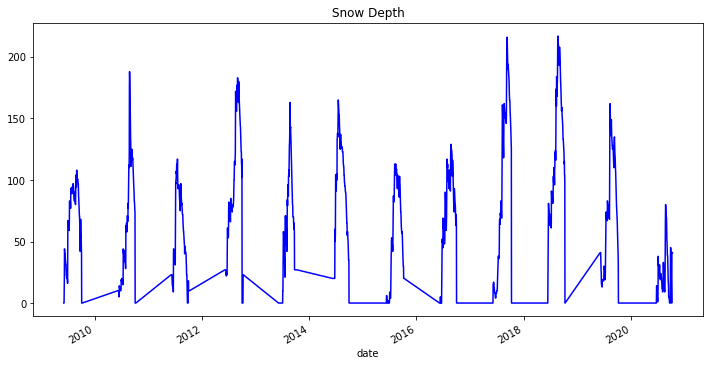

In [14]:
# display the data 
plt.figure(figsize=(12,6))
# all data points
snow_df.plot(title='Snow Depth', color='blue') 
plt.show()

The above data is based on the frequency that we need for the model, i.e. in this case (daily).  No further frequency or pandas resampling is required.  Its noted here because if hourly or minute data is presented, the resampling method can be used to simplify the data set accordingly.

The data is still not very smooth, but it shows noticeable trends, and so, makes for a good use case for machine learning models that may be able to recognize these patterns.

---
## Create Time Series 

We will look to construct time series starting at the first collected data point,  by changing `t_start` and `t_end` in the function below.

The function `make_time_series` will create pandas `Series` for each of the passed in list of years eg. `['2012', '2013', '2014']`.

* All of the time series will start at the same time point `t_start` (or t0). 
    * When preparing data, it's important to use a consistent start point for each time series; DeepAR uses this time-point as a frame of reference, which enables it to learn recurrent patterns e.g. that weekdays behave differently from weekends or that Summer is different than Winter.
    * You can change the start and end indices to define any time series you create.
* Generally, we create `Series` by getting the relevant data (from the DataFrame) and date indices.



In [16]:
def make_time_series(df, years, freq ='D'):
    '''       
      :param df: A dataframe of global power consumption, averaged by day.
       This dataframe should also be indexed by a datetime.
       
      :param years: A list of years to make time series out of, ex. ['2007', '2008'].
      :param freq: The frequency of data recording (D = daily)
      
      :return: A list of pd.Series(), time series data.
      '''
    # Initialise time_series
    time_series = []
    
    # create time series for each year in years
    start_idx = 0

    for i in range(len(years)):

        year = years[i]
        end_idx = start_idx + 127

        # create start and end datetimes, as  to be the full range
        t_start = year + '-06-05' # month/day
        t_end = year + '-10-09' # month/day
        #print(t_start)
        #print(t_end)
        
        # pass dataframe index to data.
        data = df[start_idx:end_idx]
        #print(data)
        # create time series
        
        index = pd.DatetimeIndex(pd.date_range(start = t_start, end = t_end, freq=freq))

        #print(new_series)
        time_series.append(pd.Series(data = data, index = index))
 
        
        start_idx = end_idx
    
    # return list of time series
    return time_series

## Test the results

Below, let's construct one time series for each complete year of data, and display the results.

In [17]:
# test out the code above to create a model series

# yearly time series for our three complete years, note the hold back set of 2019
years = ['2009','2010','2011','2012','2013','2014','2015','2016', '2017', '2018']

# make time series
time_series = make_time_series(snow_df, years)

In [18]:
#print(time_series)

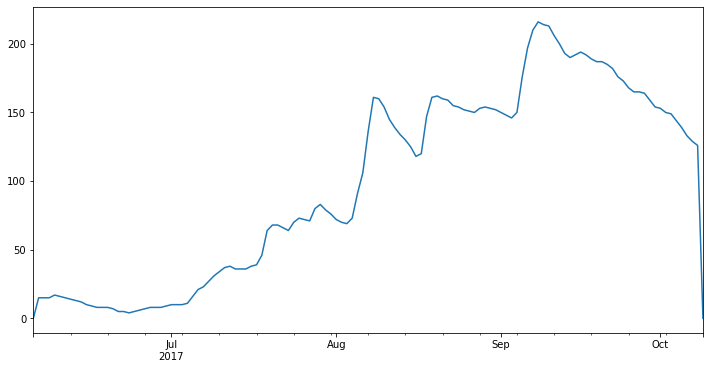

In [19]:
# display first time series
time_series_idx = 8

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

---
# Splitting in Time

We'll evaluate our model on a test set of data. For machine learning tasks like classification, we typically create train/test data by randomly splitting examples into different sets. For forecasting it's important to do this train/test split in **time** rather than by individual data points. 
> In general, we can create training data by taking each of our *complete* time series and leaving off the last `prediction_length` data points to create *training* time series. 

### EXERCISE: Create training time series

Complete the `create_training_series` function, which should take in our list of complete time series data and return a list of truncated, training time series.

* In this example, we want to predict about a month's worth of data, and we'll set `prediction_length` to 30 (days).
* To create a training set of data, we'll leave out the last 30 points of *each* of the time series we just generated, so we'll use only the first part as training data. 
* The **test set contains the complete range** of each time series.


In [20]:
prediction_length = 30 # Days

training_list = []
for ts in time_series:
    training_list.append(ts[:-prediction_length])


for ts in training_list:
    print('Training set has shape {} after truncating {} days'.format(ts.shape, prediction_length))

Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days
Training set has shape (97,) after truncating 30 days


In [21]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        # truncate trailing 30 pts
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [22]:
# set prediction length
prediction_length = 30 # days

time_series_training = create_training_series(time_series, prediction_length)

### Training and Test Series

We can visualize what these series look like, by plotting the train/test series on the same axis. We should see that the test series contains all of our data in a year, and a training series contains all but the last `prediction_length` points.

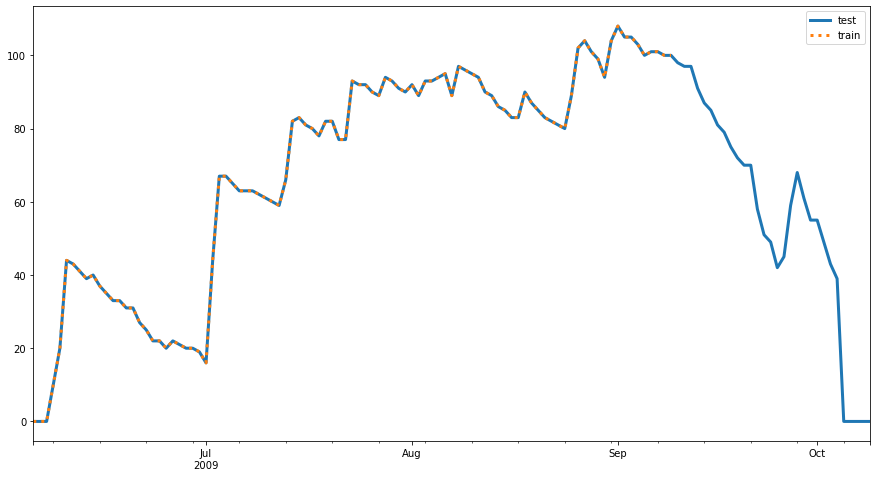

In [23]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON 

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
In the above example, each time series has one, associated categorical feature and one time series feature.

In [24]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj


In [25]:
# test out the code
ts = time_series[8]

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2017-06-05 00:00:00', 'target': [0.0, 15.0, 15.0, 15.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 10.0, 9.0, 8.0, 8.0, 8.0, 7.0, 5.0, 5.0, 4.0, 5.0, 6.0, 7.0, 8.0, 8.0, 8.0, 9.0, 10.0, 10.0, 10.0, 11.0, 16.0, 21.0, 23.0, 27.0, 31.0, 34.0, 37.0, 38.0, 36.0, 36.0, 36.0, 38.0, 39.0, 46.0, 64.0, 68.0, 68.0, 66.0, 64.0, 70.0, 73.0, 72.0, 71.0, 80.0, 83.0, 79.0, 76.0, 72.0, 70.0, 69.0, 73.0, 91.0, 106.0, 136.0, 161.0, 160.0, 154.0, 145.0, 139.0, 134.0, 130.0, 125.0, 118.0, 120.0, 147.0, 161.0, 162.0, 160.0, 159.0, 155.0, 154.0, 152.0, 151.0, 150.0, 153.0, 154.0, 153.0, 152.0, 150.0, 148.0, 146.0, 150.0, 176.0, 197.0, 210.0, 216.0, 214.0, 213.0, 206.0, 200.0, 193.0, 190.0, 192.0, 194.0, 192.0, 189.0, 187.0, 187.0, 185.0, 182.0, 176.0, 173.0, 168.0, 165.0, 165.0, 164.0, 159.0, 154.0, 153.0, 150.0, 149.0, 144.0, 139.0, 133.0, 129.0, 126.0, 0.0]}


### Saving Data, Locally

The next helper function will write one series to a single JSON line, using the new line character '\n'. The data is also encoded and written to a filename that we specify.

In [26]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [27]:
# save this data to a local directory
data_dir = 'json_snow_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [28]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_snow_data/train.json saved.
json_snow_data/test.json saved.


---
## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.

### Sagemaker resources

Let's start by specifying:
* The sagemaker role and session for training a model.
* A default S3 bucket where we can save our training, test, and model data.

In [29]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [30]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

### EXERCISE: Upoad *both* training and test JSON files to S3

Specify *unique* train and test prefixes that define the location of that data in S3.
* Upload training data to a location in S3, and save that location to `train_path`
* Upload test data to a location in S3, and save that location to `test_path`

In [31]:
# general prefix
prefix='deepar-snow'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [32]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-063367546093/deepar-snow/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-063367546093/deepar-snow/test/test.json


---
# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [33]:
# Configure the container image to be used for the region we are running in.

from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


### EXERCISE: Instantiate an Estimator 

You can now define the estimator that will launch the training job. A generic Estimator will be defined by the usual constructor arguments and an `image_name`. 
> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.


In [34]:
from sagemaker.estimator import Estimator

from sagemaker.amazon.amazon_estimator import get_image_uri

image_uri = get_image_uri(boto3.Session().region_name, "forecasting-deepar")

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)


estimator = sagemaker.estimator.Estimator(
    sagemaker_session = sagemaker_session,
    image_uri=image_uri,
    role = role,
    train_instance_count = 1,
    train_instance_type = 'ml.c4.xlarge',
    output_path = s3_output_path
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

Typically, it is recommended that you start with a `context_length`=`prediction_length`. This is because a DeepAR model also receives "lagged" inputs from the target time series, which allow the model to capture long-term dependencies. For example, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality. 

The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. You can read more about this in the [DeepAR "how it works" documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

### Optional Hyperparameters

You can also configure optional hyperparameters to further tune your model. These include parameters like the number of layers in our RNN model, the number of cells per layer, the likelihood function, and the training options, such as batch size and learning rate. 

For an exhaustive list of all the different DeepAR hyperparameters you can refer to the DeepAR [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [76]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "100",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [77]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training Job

Now, we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series. The computed error metrics will be included as part of the log output.

The next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [78]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2021-08-16 09:34:39 Starting - Starting the training job...
2021-08-16 09:35:03 Starting - Launching requested ML instancesProfilerReport-1629106478: InProgress
...
2021-08-16 09:35:36 Starting - Preparing the instances for training.........
2021-08-16 09:37:03 Downloading - Downloading input data
2021-08-16 09:37:03 Training - Downloading the training image......
2021-08-16 09:38:03 Training - Training image download completed. Training in progress.Arguments: train
[08/16/2021 09:38:03 INFO 140719824602496] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layer

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [38]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=JSONSerializer(),
    deserializer= JSONDeserializer()
)

-------------------!

---
# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```


## JSON Prediction Request

The code below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [40]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}
   
    #json_request = json.dumps(request_data).encode('utf-8')https://github.com/udacity/ML_SageMaker_Studies/issues/14

    #return json_request https://github.com/udacity/ML_SageMaker_Studies/issues/14
    return request_data

### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [41]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

In [42]:
# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

In [43]:
print(json_input_ts)

{'instances': [{'start': '2009-06-05 00:00:00', 'target': [0.0, 0.0, 0.0, 10.0, 20.0, 44.0, 43.0, 41.0, 39.0, 40.0, 37.0, 35.0, 33.0, 33.0, 31.0, 31.0, 27.0, 25.0, 22.0, 22.0, 20.0, 22.0, 21.0, 20.0, 20.0, 19.0, 16.0, 44.0, 67.0, 67.0, 65.0, 63.0, 63.0, 63.0, 62.0, 61.0, 60.0, 59.0, 66.0, 82.0, 83.0, 81.0, 80.0, 78.0, 82.0, 82.0, 77.0, 77.0, 93.0, 92.0, 92.0, 90.0, 89.0, 94.0, 93.0, 91.0, 90.0, 92.0, 89.0, 93.0, 93.0, 94.0, 95.0, 89.0, 97.0, 96.0, 95.0, 94.0, 90.0, 89.0, 86.0, 85.0, 83.0, 83.0, 90.0, 87.0, 85.0, 83.0, 82.0, 81.0, 80.0, 89.0, 102.0, 104.0, 101.0, 99.0, 94.0, 104.0, 108.0, 105.0, 105.0, 103.0, 100.0, 101.0, 101.0, 100.0, 100.0]}, {'start': '2010-06-05 00:00:00', 'target': [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 5.0, 14.0, 13.0, 13.0, 12.0, 11.0, 11.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 12.0, 19.0, 18.0, 18.0, 18.0, 18.0, 20.0, 19.0, 19.0, 19.0, 19.0, 17.0, 15.0, 15.0, 15.0, 44.0, 41.0, 41.0, 40.0, 43.0, 43.0, 42.0, 41.0, 37.0, 36.0, 34.0, 

In [44]:
# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

print(json_prediction)

{'predictions': [{'quantiles': {'0.1': [94.9594955444, 91.9298171997, 91.1225280762, 87.0200195312, 83.9540176392, 87.6431884766, 83.2997283936, 80.3437271118, 78.1681747437, 77.3086471558, 77.2043685913, 74.4141616821, 69.4968719482, 68.0678100586, 68.2322158813, 65.7500228882, 67.1639328003, 62.6811447144, 62.8915405273, 63.5150299072, 61.0132751465, 60.0494766235, 58.5965805054, 54.6053733826, 51.9319458008, 49.9057617188, 49.8916854858, 53.8492355347, 53.86561203, 55.0143508911], '0.5': [101.9262695312, 101.5504760742, 101.2879257202, 102.0402450562, 101.1163330078, 102.3278427124, 99.6101303101, 98.635597229, 98.4497528076, 99.3261795044, 99.4754943848, 98.033164978, 95.36769104, 92.4756240845, 90.4615936279, 88.7855758667, 91.1010360718, 86.5654067993, 83.7716064453, 83.2516937256, 79.0873794556, 78.4468383789, 80.9350814819, 75.0077056885, 70.24559021, 68.4880218506, 69.5762329102, 69.8179244995, 70.6007843018, 70.7162704468], '0.9': [108.5096588135, 110.9881210327, 115.44554901

## Decoding Predictions

The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.

In [45]:
def decode_prediction(prediction_data):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    #prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [46]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions with corresponding quantile values
print(prediction_list[0])

          0.1         0.5         0.9
0   94.959496  101.926270  108.509659
1   91.929817  101.550476  110.988121
2   91.122528  101.287926  115.445549
3   87.020020  102.040245  117.603134
4   83.954018  101.116333  117.253578
5   87.643188  102.327843  122.888016
6   83.299728   99.610130  117.645363
7   80.343727   98.635597  119.185364
8   78.168175   98.449753  119.716866
9   77.308647   99.326180  119.018860
10  77.204369   99.475494  124.297295
11  74.414162   98.033165  118.126663
12  69.496872   95.367691  121.392929
13  68.067810   92.475624  119.229248
14  68.232216   90.461594  116.713928
15  65.750023   88.785576  126.565781
16  67.163933   91.101036  123.352470
17  62.681145   86.565407  120.647568
18  62.891541   83.771606  118.797089
19  63.515030   83.251694  117.175423
20  61.013275   79.087379  111.667099
21  60.049477   78.446838  117.197655
22  58.596581   80.935081  114.124283
23  54.605373   75.007706  104.440239
24  51.931946   70.245590  119.565308
25  49.90576

## Display the Results!

The quantile data will give us what we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.


In [47]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

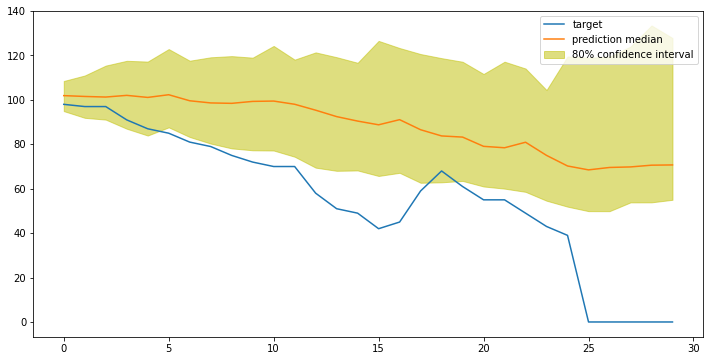

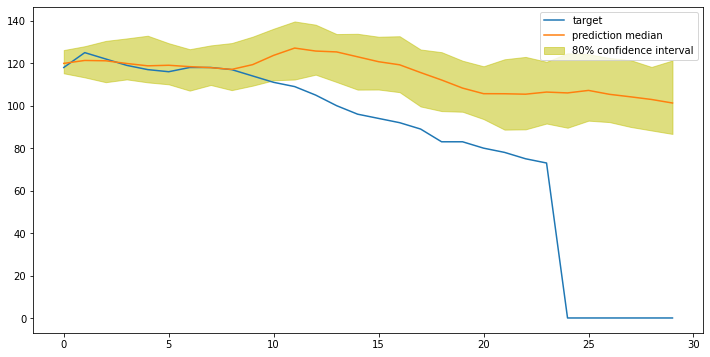

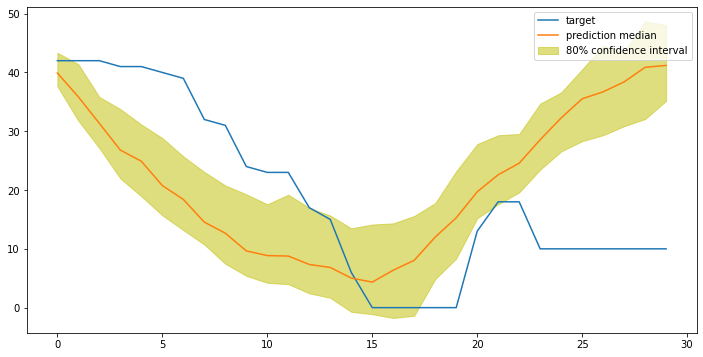

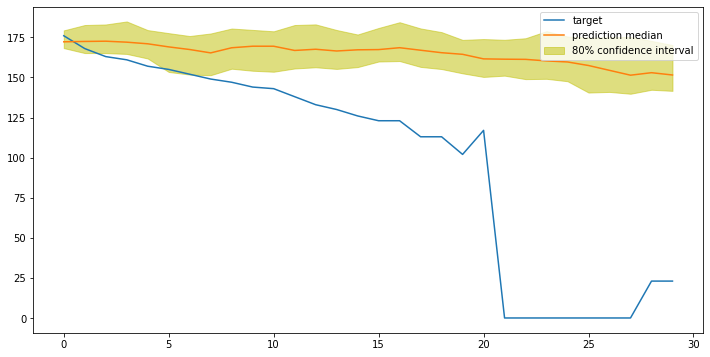

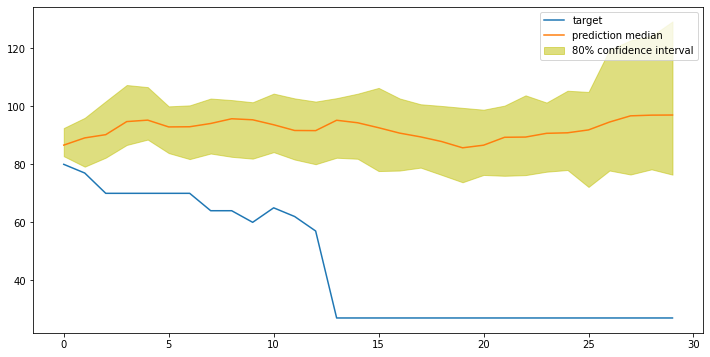

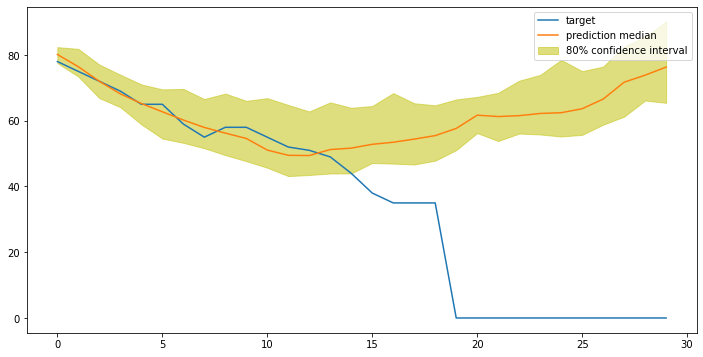

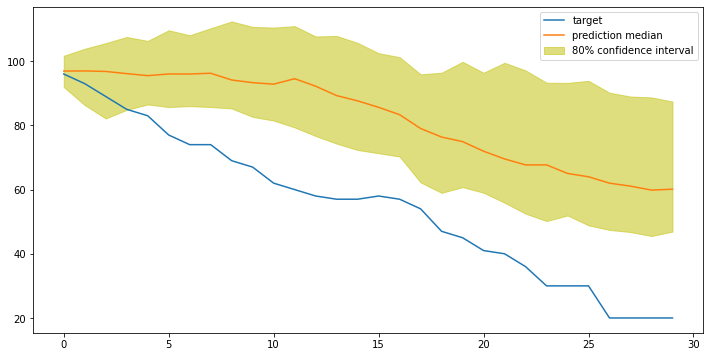

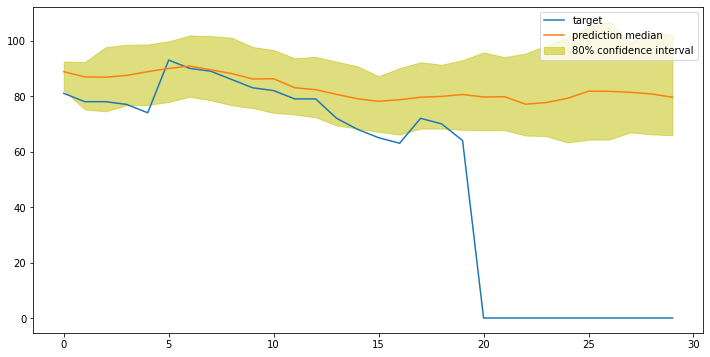

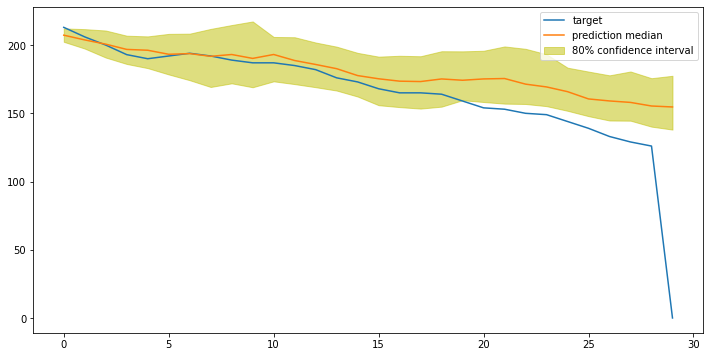

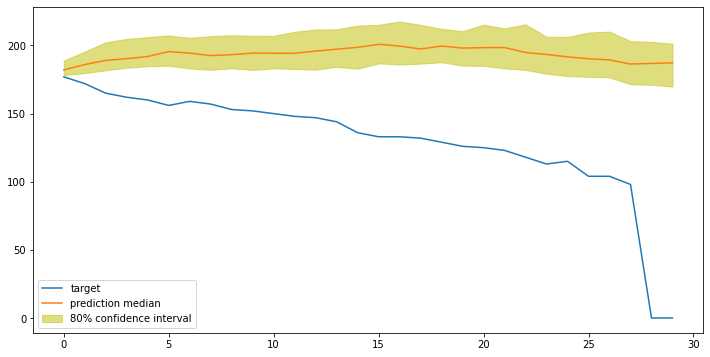

In [48]:
# display predictions
display_quantiles(prediction_list, target_ts)

## Predicting the Future

Recall that we did not give our model any data about 2010, but let's see if it can predict the energy consumption given **no target**, only a known start date!

### EXERCISE: Format a request for a "future" prediction

Create a formatted input to send to the deployed `predictor` passing parameters for "configuration". The "instances" will, in this case, just be one instance, defined by the following:
* **start**: The start time will be time stamp that you specify. To predict the first 30 days of 2019
* **target**: The target will be an empty list because this year has no, complete associated time series; we specifically withheld that information from our model, for testing purposes.
```
{"start": start_time, "target": []} # empty target
```

In [49]:
# Starting prediction at the beginning of 2019
start_date = '2019-06-05'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

#json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2019-06-05 00:00:00


Then get and decode the prediction response, as usual.

In [50]:
# get prediction response
json_prediction = predictor.predict(request_data)

prediction_2019 = decode_prediction(json_prediction)

In [55]:
prediction_2019

[          0.1       0.5        0.9
 0   -5.711397  6.585489  18.256195
 1   -6.529844  4.371387  15.803688
 2   -6.850800  3.507356  21.198975
 3   -7.925625  3.486017  18.806007
 4   -8.219657  2.204297  15.883496
 5   -9.158485  3.650648  17.284718
 6   -9.274893  2.160238  13.850934
 7  -11.582704  1.261238  15.177574
 8   -8.227002  2.244069  15.758569
 9   -8.985703  1.877936  18.262871
 10  -8.284867  2.754916  18.389997
 11  -8.443373  1.718785  17.790398
 12  -9.623629  1.737199  20.002110
 13 -10.534702  1.082294  18.862793
 14  -7.343797  2.923945  18.636906
 15  -8.887796  1.498589  19.689293
 16  -7.061844  3.941325  19.802317
 17  -5.630174  4.103911  19.103933
 18  -4.626318  4.545717  20.083096
 19  -5.283682  5.904924  21.074087
 20  -3.065374  5.121702  20.599369
 21  -2.352920  5.700289  19.588112
 22  -1.477430  5.952797  19.220320
 23  -2.848316  6.599425  19.262394
 24  -1.598557  8.024078  21.666502
 25  -0.368446  8.927527  18.222046
 26  -0.412580  8.898695  21

In [73]:
#Snow Depth Information

url = 'https://raw.githubusercontent.com/boffyd/UdacityML-Capstone/main/Data/pred1.csv'

dfp1 = pd.read_csv(url)
dfp1['mean'].copy()
dfp1.head()

,mean
0,6.585489
1,4.371387
2,3.507356
3,3.486017
4,2.204297


In [75]:
accuracy(df_base_30,dfp1)

Mean Absolute Error (MAE): 19.290462199999997
Root Mean Squared Error (RMSE): 21.067965108643744


Finally, compare the predictions to a known target sequence. This target will come from a time series for the 2019 data

In [51]:
# create 2019 time series
ts_2019 = []

# get global consumption data
# index 1112 is where the 2010 data starts
data_2019 = df_base_30

print(data_2019)

index = pd.DatetimeIndex(pd.date_range(start = start_date, periods=len(data_2019), freq='D'))

ts_2019.append(pd.Series(data = data_2019, index = index))

date
2019-06-05    41.0
2019-06-06    41.0
2019-06-07    41.0
2019-06-08    41.0
2019-06-09    36.0
2019-06-10    31.0
2019-06-11    26.0
2019-06-12    25.0
2019-06-13    16.0
2019-06-14    15.0
2019-06-15    15.0
2019-06-16    15.0
2019-06-17    15.0
2019-06-18    13.0
2019-06-19    19.0
2019-06-20    19.0
2019-06-21    19.0
2019-06-22    19.0
2019-06-23    19.0
2019-06-24    19.0
2019-06-25    19.0
2019-06-26    18.0
2019-06-27    18.0
2019-06-28    18.0
2019-06-29    18.0
2019-06-30    27.0
2019-07-01    30.0
2019-07-02    28.0
2019-07-03    28.0
2019-07-04    28.0
Name: snow_depth, dtype: float64


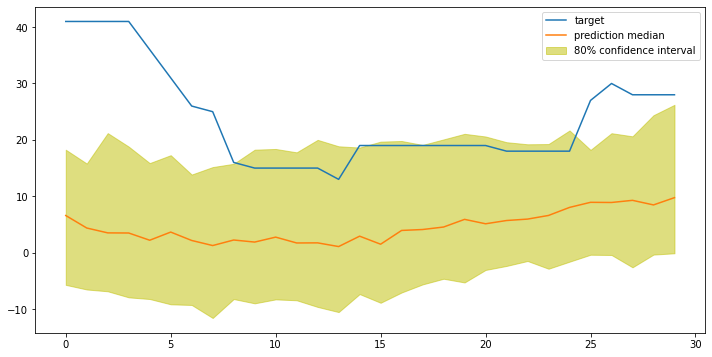

In [52]:
# range of actual data to compare
start_idx = 0

end_idx = start_idx + prediction_length

# get target data
target_2019_ts = [ts_2019[0][start_idx:end_idx]]

# display predictions
display_quantiles(prediction_2019, target_2019_ts)

## Delete the Endpoint